In [1]:
import pandas as pd
import sys
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
module_path = os.path.abspath(os.path.join('..'))    

if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src.db.session import engine

query = "SELECT * FROM ads"

df = pd.read_sql(query, con=engine)

In [4]:
display(df.head())

,avito_id,url,title,price,description,location,published_at,condition,seller_name,seller_rating,seller_reviews_count
0,7695007829,https://www.avito.ru/moskva/telefony/iphone_11...,"iPhone 11, 64 ГБ",10000,"Продаю айфон 11, айклауд взломали.",Москва,2025-10-08 16:01:32.990590+00:00,Б/у,Анна,4.8,16.0
1,7743661402,https://www.avito.ru/moskva/telefony/iphone_11...,"iPhone 11, 64 ГБ",10998,"Продаю iphone 11 на 64гб в хорошем состоянии, ...",Москва,2025-10-08 14:01:32.998022+00:00,Б/у,None,NaN,NaN
2,7684049927,https://www.avito.ru/moskva/telefony/iphone_11...,"iPhone 11, 64 ГБ",9000,Телефон в рабочем состоянии. Трещина не мешают...,Москва,2025-10-08 13:01:33.003023+00:00,Б/у,None,NaN,NaN
3,7789880055,https://www.avito.ru/moskva/telefony/iphone_11...,"iPhone 11, 64 ГБ",9500,"Телефон в хорошем состоянии, работает отлично....",Москва,2025-10-08 13:01:33.007280+00:00,Б/у,None,NaN,NaN
4,7674616969,https://www.avito.ru/moskva/telefony/iphone_11...,"iPhone 11, 64 ГБ",12990,Телефон в отличном состоянии!\n\nРодной Акб 89...,Москва,2025-10-08 13:01:33.011891+00:00,Б/у,AppleRoom,5.0,2.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   avito_id              1014 non-null   int64              
 1   url                   1014 non-null   object             
 2   title                 1014 non-null   object             
 3   price                 1014 non-null   int64              
 4   description           1013 non-null   object             
 5   location              1014 non-null   object             
 6   published_at          1014 non-null   datetime64[ns, UTC]
 7   condition             1014 non-null   object             
 8   seller_name           449 non-null    object             
 9   seller_rating         429 non-null    float64            
 10  seller_reviews_count  429 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(6)
memory usa

In [6]:
display(df['price'].describe())

count     1014.000000
mean     28371.678501
std       5948.985256
min       4200.000000
25%      25000.000000
50%      27990.000000
75%      30490.000000
max      80000.000000
Name: price, dtype: float64

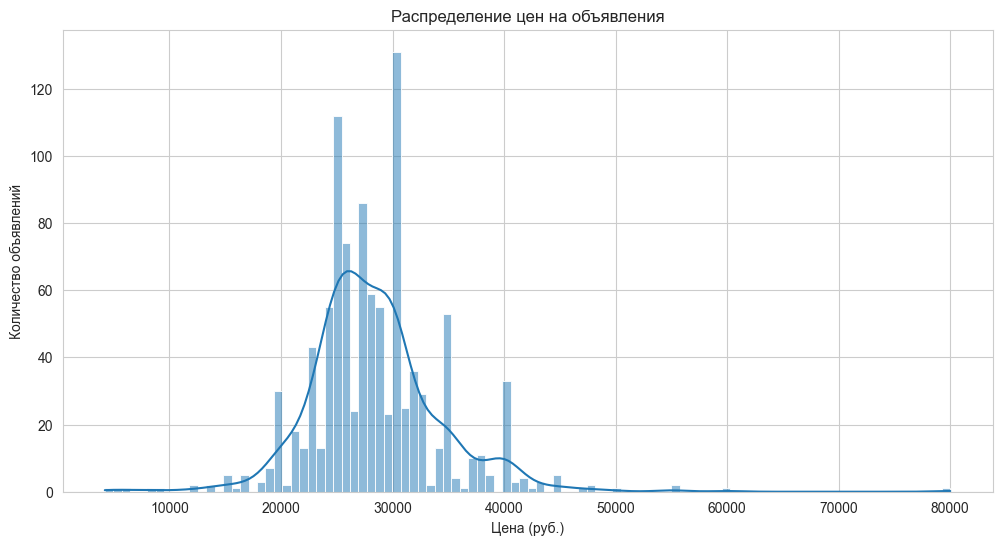

In [7]:
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], bins=100, kde=True)
plt.title("Распределение цен на объявления")
plt.xlabel("Цена (руб.)")
plt.ylabel("Количество объявлений")
plt.show()

Отбрасываем цены ниже 15000 руб. и выше 45000 руб.
Размер исходного датафрейма: 1014
Размер отфильтрованного датафрейма: 988


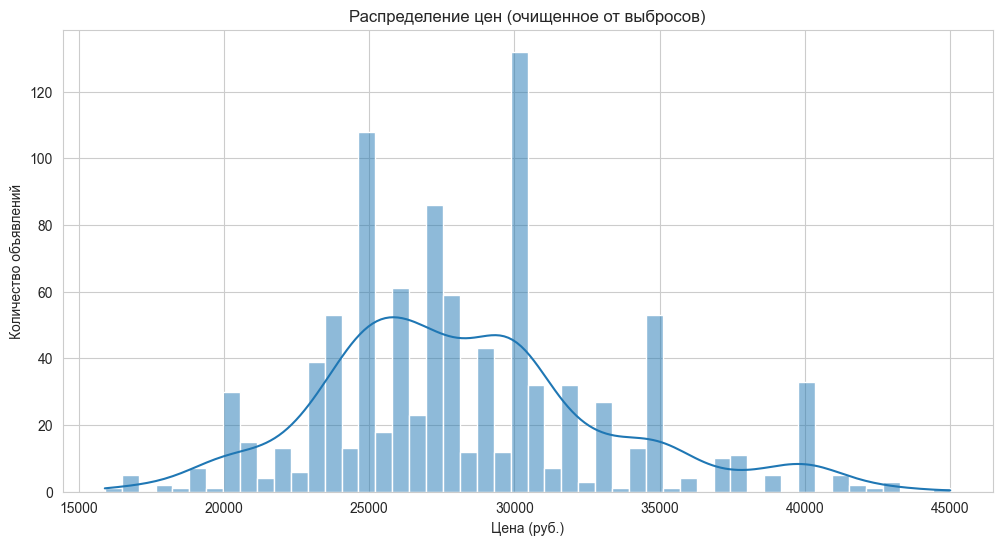

In [8]:
min_threshold = df['price'].quantile(0.01)
max_threshold = df['price'].quantile(0.99)

print(f"Отбрасываем цены ниже {min_threshold:.0f} руб. и выше {max_threshold:.0f} руб.")

df_filtered = df[(df['price'] > min_threshold) & (df['price'] < max_threshold)]

print(f"Размер исходного датафрейма: {len(df)}")
print(f"Размер отфильтрованного датафрейма: {len(df_filtered)}")

plt.figure(figsize=(12, 6))
sns.histplot(df_filtered['price'], bins=50, kde=True)
plt.title("Распределение цен (очищенное от выбросов)")
plt.xlabel("Цена (руб.)")
plt.ylabel("Количество объявлений")
plt.show()

In [9]:
display(df_filtered['price'].describe())

count      988.000000
mean     28326.501012
std       4912.676195
min      15900.000000
25%      25000.000000
50%      27990.000000
75%      30000.000000
max      44999.000000
Name: price, dtype: float64

In [10]:
print("Количество объявлений по состоянию:")
display(df_filtered['condition'].value_counts())

Количество объявлений по состоянию:


condition
Б/у    988
Name: count, dtype: int64

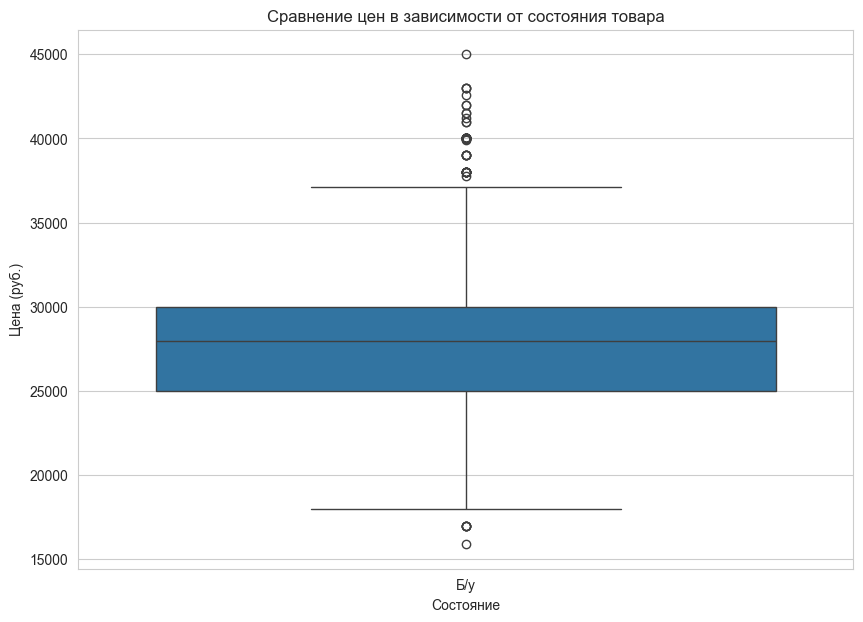

In [11]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='condition', y='price', data=df_filtered)
plt.title("Сравнение цен в зависимости от состояния товара")
plt.xlabel("Состояние")
plt.ylabel("Цена (руб.)")
plt.show()

Анализируем 423 объявлений с информацией о продавце.


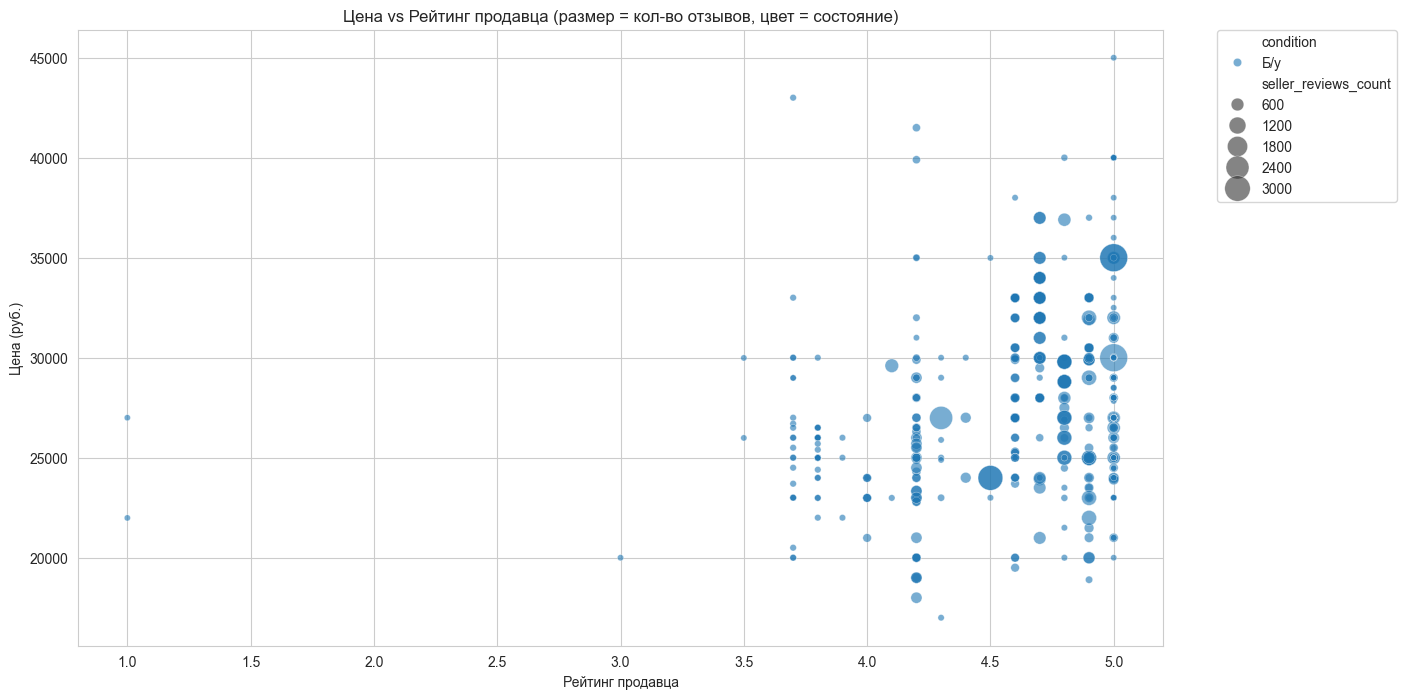

In [12]:
df_with_sellers = df_filtered[df_filtered['seller_reviews_count'] > 0].copy()
print(f"Анализируем {len(df_with_sellers)} объявлений с информацией о продавце.")

plt.figure(figsize=(14, 8))
sns.scatterplot(
    x='seller_rating',
    y='price',                                      
    hue='condition',                                                                           
    size='seller_reviews_count',
    sizes=(20, 400),
    alpha=0.6,
    data=df_with_sellers
)
plt.title("Цена vs Рейтинг продавца (размер = кол-во отзывов, цвет = состояние)")
plt.xlabel("Рейтинг продавца")
plt.ylabel("Цена (руб.)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

Количество объявлений по объему памяти:


C:\Users\k1ree8\AppData\Local\Temp\ipykernel_12816\370594333.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['memory_gb'] = df_filtered['title'].apply(extract_memory)


memory_gb
128.0    650
256.0    271
512.0     46
Name: count, dtype: int64

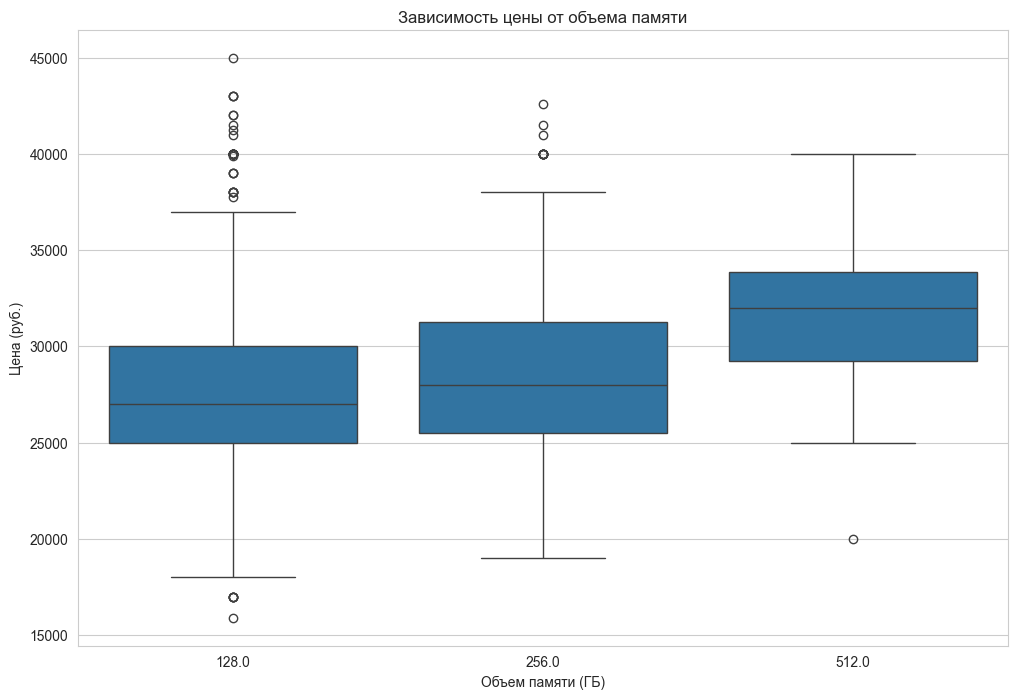

In [13]:
def extract_memory(title):
    match = re.search(r'(\d+)\s*гб', title, re.IGNORECASE)
    if match:
        return int(match.group(1))
    return None

df_filtered['memory_gb'] = df_filtered['title'].apply(extract_memory)

print("Количество объявлений по объему памяти:")
display(df_filtered['memory_gb'].value_counts())

plt.figure(figsize=(12, 8))
sns.boxplot(x='memory_gb', y='price', data=df_filtered)
plt.title("Зависимость цены от объема памяти")
plt.xlabel("Объем памяти (ГБ)")
plt.ylabel("Цена (руб.)")
plt.show()

In [14]:
features_to_use = [
    'price',
    'condition',
    'seller_rating',
    'seller_reviews_count',
    'memory_gb'
]

df_model = df_filtered[features_to_use].copy()

df_model.dropna(inplace=True)

print(f"Размер датафрейма после удаления пропусков: {len(df_model)}")

df_model = pd.get_dummies(df_model, columns=['condition', 'memory_gb'], drop_first=True)

X = df_model.drop('price', axis=1)
y = df_model['price']

print("Матрица признаков X (первые 5 строк):")
display(X.head())

print("Целевая переменная y (первые 5 строк):")
display(y.head())

X.info()

Размер датафрейма после удаления пропусков: 403
Матрица признаков X (первые 5 строк):


,seller_rating,seller_reviews_count,memory_gb_256.0,memory_gb_512.0
3,5.0,1.0,False,False
4,4.8,47.0,False,False
7,5.0,226.0,True,False
8,4.5,8.0,True,False
11,4.8,19.0,False,False


Целевая переменная y (первые 5 строк):


3     30000
4     28000
7     28000
8     34990
11    20000
Name: price, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 403 entries, 3 to 1011
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   seller_rating         403 non-null    float64
 1   seller_reviews_count  403 non-null    float64
 2   memory_gb_256.0       403 non-null    bool   
 3   memory_gb_512.0       403 non-null    bool   
dtypes: bool(2), float64(2)
memory usage: 10.2 KB


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки: {X_train.shape[0]} записей")
print(f"Размер тестовой выборки: {X_test.shape[0]} записей")

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

print(f"Средняя абсолютная ошибка (MAE) на тестовой выборке: {mae:.2f} руб.")

Размер обучающей выборки: 322 записей
Размер тестовой выборки: 81 записей
Средняя абсолютная ошибка (MAE) на тестовой выборке: 2968.69 руб.


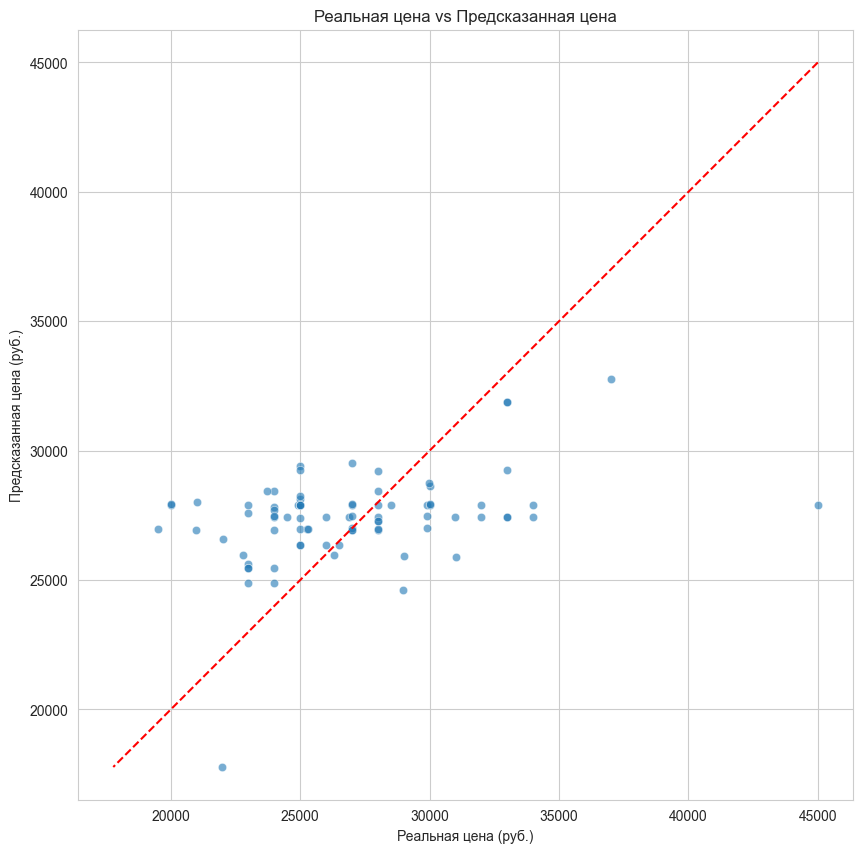

In [16]:
results_df = pd.DataFrame({'Реальная цена': y_test, 'Предсказанная цена': y_pred})

plt.figure(figsize=(10, 10))
sns.scatterplot(x='Реальная цена', y='Предсказанная цена', data=results_df, alpha=0.6)

p1 = max(max(y_test), max(y_pred))
p2 = min(min(y_test), min(y_pred))
plt.plot([p1, p2], [p1, p2], 'r--')

plt.title("Реальная цена vs Предсказанная цена")
plt.xlabel("Реальная цена (руб.)")
plt.ylabel("Предсказанная цена (руб.)")
plt.axis('equal')
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

print(f"Средняя квадратичная ошибка (MSE): {mse:.2f}")
print(f"Корень из средней квадратичной ошибки (RMSE): {rmse:.2f} руб.")
print(f"Напоминание: Средняя абсолютная ошибка (MAE): {mae:.2f} руб.")

print(f"\nРазница между RMSE и MAE: {rmse - mae:.2f} руб.")

Средняя квадратичная ошибка (MSE): 15171181.78
Корень из средней квадратичной ошибки (RMSE): 3895.02 руб.
Напоминание: Средняя абсолютная ошибка (MAE): 2968.69 руб.

Разница между RMSE и MAE: 926.33 руб.


In [18]:
intercept = model.intercept_
print(f"Свободный член (intercept), β₀: {intercept:.2f} руб.")

coefficients = model.coef_

feature_weights = pd.Series(coefficients, index=X.columns)

print("\nВеса признаков (коэффициенты), β₁, β₂, ...:")
display(feature_weights.sort_values(ascending=False))

Свободный член (intercept), β₀: 15242.71 руб.

Веса признаков (коэффициенты), β₁, β₂, ...:


memory_gb_512.0         4863.770575
seller_rating           2531.480713
memory_gb_256.0         1478.421242
seller_reviews_count       0.522437
dtype: float64